# Лабораторная работа №3

ФИО: Хайдукова Мария Игоревна  
Группа: БИВТ-23-СП-3

Что необходимо сделать:  
- Обучить различного рода модели машинного обучения и сравнить их между собой  
  
---
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии (**если у вас многоклассовая классификация, прочтите P.S.S. внизу**).
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Обучить на тренировочном множестве:
     1. Линейную модель (`LogisticRegression`, `LinearRegression`)
     2. Деревянную модель (`DecisionTreeClassifier`, `DecisionTreeRegressor`) (тут советую попробовать разные глубины деревьев)
     3. K-ближайших соседей (`KNeighborsClassifier`, `KNeighborsRegressor`) (тут тоже есть смысл попробовать разные `k`)
     4. Случайный лес (`RandomForestClassifier`, `RandomForestRegressor`) 
5. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy, ROC-AUC (график + значение), PR-кривую (график), F1-score
     2. Для задачи регрессии -- MAE, RMSE, MAPE
6. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

P.S.S.  
Если вам повезло с многоклассовой классификацией, вам будет необходимо понять, умеет ли алгоритм работать с несколькими классами одновременно (обычно они не умеют). Поэтому вам может понадобиться такая штука, как OneVsRestClassifier ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier)), но советую ознакомиться с этой [страницей](https://scikit-learn.org/stable/modules/multiclass.html), здесь представлена более полная информация.

## 1. Пример импорта данных. Грузим данные

In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                            classification_report, confusion_matrix, 
                            roc_curve, precision_recall_curve, 
                            mean_absolute_error, mean_squared_error)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [217]:
data = pd.read_csv('data/students_adaptability_level_online_education.csv')

## 2. Понимаем, какая перед нами задача

In [255]:
data.head(2)

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate


In [9]:
print(data['Adaptivity Level'].nunique())
print(data['Adaptivity Level'].unique())

3
['Moderate' 'Low' 'High']


#### На лицо задача многоклассовой классификации, тк присутствует точное перечесление 3х классов
---

## 3. Делаем предобработку данных

### Предобработка

- Разделить выборку на тренировочную (train) и тестовую (test). Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test.
- Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
- Отнормировать численные переменные (StandardScaler, MinMaxScaler).
- Закодировать категориальные признаки по одной из стратегий.

In [115]:
X = data.drop(columns='Adaptivity Level')
y = data['Adaptivity Level']

In [121]:
X = X.drop(columns='Age')

Исходные данные содержали категориальные признаки в текстовом формате (object), что непригодно для машинного обучения. Для преобразования в числовой формат был применен метод ручного преобразования (manual mapping) с использованием бинарного кодирования.  

Каждому текстовому значению присваивается соответствующее числовое значение. Для бинарных признаков (Yes/No) используется схема: {'No': 0, 'Yes': 1}. Для порядковых признаков сохраняется естественная иерархия.

---

In [196]:
X.head()

,Gender,avg_Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type _G,Class Duration,Self Lms,Device
0,0,23,2,0,0,1,0,1,0,4,2,0,0
1,1,23,2,0,0,1,1,1,1,4,1,1,1
2,1,18,1,1,0,1,0,1,0,4,1,0,1
3,1,13,0,0,0,1,0,1,1,4,1,0,1
4,1,18,0,0,0,1,0,0,1,3,0,0,1


In [192]:
X['Network Type _G'].unique()

array([ 4.,  3., nan])

In [193]:
X['Network Type _G_missing'] = X['Network Type _G'].isna().astype('int8')

most_common = X['Network Type _G'].mode()[0]
X['Network Type _G'] = X['Network Type _G'].fillna(most_common).astype('int64')

In [195]:
X = X.drop(columns='Network Type _G_missing')

In [183]:
device_map = {'Tab': 0, 'Mobile': 1, 'Computer': 2}
X['Device'] = X['Device'].map(device_map)

In [180]:
X['Self Lms'] = X['Self Lms'].map({'No': 0, 'Yes' : 1})

In [176]:
duration_order = {'0': 0, '1-3': 1, '3-6': 2}
X['Class Duration'] = X['Class Duration'].map(duration_order)

In [169]:
X = X.rename(columns={'Network Type': 'Network Type _G'})

In [172]:
X['Network Type _G'] = X['Network Type _G'].map({'4G' : 4, '3G' : 3, '5G' : 5})

In [136]:
X['Internet Type'] = X['Internet Type'].map({'Wifi': 0, 'Mobile Data' : 1})

In [133]:
X['Financial Condition'] = X['Financial Condition'].map({'Poor': 0, 'Mid' : 1, 'Rich' : 2})

In [125]:
X['Load-shedding'] = X['Load-shedding'].map({'Low': 0, 'High' : 1})

In [126]:
X['Location'] = X['Location'].map({'No': 0, 'Yes' : 1})

In [127]:
X['IT Student'] = X['IT Student'].map({'No': 0, 'Yes' : 1})

In [128]:
X['Institution Type'] = X['Institution Type'].map({'Non Government': 0, 'Government' : 1})

In [129]:
X['Education Level'] = X['Education Level'].map({'School': 0, 'College': 1, 'University': 2})

In [130]:
X['Gender'] = X['Gender'].map({'Girl': 1, 'Boy': 0})

In [118]:
X['avg_Age'] = X['Age'].map({'1-5': 3, '6-10': 8, '11-15': 13, '16-20': 18, '21-25': 23, '26-30': 28})

In [119]:
target_col = X.pop('avg_Age')
X.insert(2, 'avg_Age', target_col)

---
После завершения процесса кодирования категориальных признаков была проведена проверка типов данных. В результате верификации подтверждено, что все признаки в таблице представлены в числовом формате `int64`.

In [256]:
X.dtypes

Gender                 int64
avg_Age                int64
Education Level        int64
Institution Type       int64
IT Student             int64
Location               int64
Load-shedding          int64
Financial Condition    int64
Internet Type          int64
Network Type _G        int64
Class Duration         int64
Self Lms               int64
Device                 int64
dtype: object

---
Для оценки качества моделей и предотвращения переобучения исходный датасет был разделен на обучающую и тестовую выборки с использованием функции train_test_split из библиотеки scikit-learn. Также проверяем на этом шаге пропуски.

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [204]:
print("Пропуски в TRAIN:")
print(X_train.isna().sum())

print("\nПропуски в TEST:")  
print(X_test.isna().sum())

Пропуски в TRAIN:
Gender                 0
avg_Age                0
Education Level        0
Institution Type       0
IT Student             0
Location               0
Load-shedding          0
Financial Condition    0
Internet Type          0
Network Type _G        0
Class Duration         0
Self Lms               0
Device                 0
dtype: int64

Пропуски в TEST:
Gender                 0
avg_Age                0
Education Level        0
Institution Type       0
IT Student             0
Location               0
Load-shedding          0
Financial Condition    0
Internet Type          0
Network Type _G        0
Class Duration         0
Self Lms               0
Device                 0
dtype: int64


#### Пропусков нет
---

#### Анализ диапазонов числовых признаков показал, что большинство переменных уже находятся в оптимальном масштабе (0-1 или 0-2), что соответствует бинарным и категориальным закодированным признакам. Однако признак avg_Age имеет значительно больший диапазон значений (3-28), что может негативно повлиять на работу некоторых алгоритмов машинного обучения.

In [209]:
for col in X_train.columns:
    unique_vals = sorted(X_train[col].unique())
    print(f"{col}: {unique_vals} (диапазон: {min(unique_vals)}-{max(unique_vals)})")

Gender: [np.int64(0), np.int64(1)] (диапазон: 0-1)
avg_Age: [np.int64(3), np.int64(8), np.int64(13), np.int64(18), np.int64(23), np.int64(28)] (диапазон: 3-28)
Education Level: [np.int64(0), np.int64(1), np.int64(2)] (диапазон: 0-2)
Institution Type: [np.int64(0), np.int64(1)] (диапазон: 0-1)
IT Student: [np.int64(0), np.int64(1)] (диапазон: 0-1)
Location: [np.int64(0), np.int64(1)] (диапазон: 0-1)
Load-shedding: [np.int64(0), np.int64(1)] (диапазон: 0-1)
Financial Condition: [np.int64(0), np.int64(1), np.int64(2)] (диапазон: 0-2)
Internet Type: [np.int64(0), np.int64(1)] (диапазон: 0-1)
Network Type _G: [np.int64(3), np.int64(4)] (диапазон: 3-4)
Class Duration: [np.int64(0), np.int64(1), np.int64(2)] (диапазон: 0-2)
Self Lms: [np.int64(0), np.int64(1)] (диапазон: 0-1)
Device: [np.int64(0), np.int64(1), np.int64(2)] (диапазон: 0-2)


In [212]:
scaler = StandardScaler()
X_train['avg_Age_scaled'] = scaler.fit_transform(X_train[['avg_Age']])

X_test['avg_Age_scaled'] = scaler.transform(X_test[['avg_Age']])

X_train = X_train.drop('avg_Age', axis=1)
X_test = X_test.drop('avg_Age', axis=1)

In [257]:
X_train['avg_Age_scaled'].unique()

array([ 0.13480795,  0.9463518 , -0.6767359 , -1.48827976, -2.29982361,
        1.75789566])

In [215]:
X_train.head()

,Gender,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type _G,Class Duration,Self Lms,Device,avg_Age_scaled
1131,1,1,0,0,1,0,1,0,4,1,0,1,0.134808
517,0,2,0,1,1,0,2,0,4,1,1,2,0.946352
73,1,0,0,0,1,0,0,1,3,1,0,1,-0.676736
441,0,1,0,0,1,0,1,0,4,1,0,1,0.134808
1034,1,2,0,1,1,0,2,0,4,2,0,2,0.946352


#### Для признака avg_Age было применено масштабирование с использованием StandardScaler с целью приведения к нормальному распределению.
---

Все этапы предобработки данных успешно завершены, и итоговый датасет полностью подготовлен для построения прогнозных моделей. Были выполнены следующие ключевые этапы: кодирование категориальных признаков с преобразованием в числовой формат, разделение на train/test выборки для валидной оценки моделей, масштабирование признаков через нормализацию числовых переменных и валидация типов данных с проверкой корректности преобразований.

В результате:

- Все признаки представлены в числовом формате,
- Данные разделены на обучающую и тестовую выборки,
- Признаки приведены к сопоставимым масштабам,
- Отсутствуют пропущенные значения.

Датасет теперь полностью готов для обучения моделей машинного обучения и выявления закономерностей, влияющих на целевой признак "Adaptivity Level".

## 4. Обучим на тренировочном множестве

1. Линейную модель (`LogisticRegression`, `LinearRegression`)
2. Деревянную модель (`DecisionTreeClassifier`, `DecisionTreeRegressor`) (тут советую попробовать разные глубины деревьев)
3. K-ближайших соседей (`KNeighborsClassifier`, `KNeighborsRegressor`) (тут тоже есть смысл попробовать разные `k`)
4. Случайный лес (`RandomForestClassifier`, `RandomForestRegressor`) 

In [226]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

tree_depth3 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_depth5 = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_depth10 = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_default = DecisionTreeClassifier(random_state=42)

tree_depth3.fit(X_train, y_train)
tree_depth5.fit(X_train, y_train)
tree_depth10.fit(X_train, y_train)
tree_default.fit(X_train, y_train)

knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn10 = KNeighborsClassifier(n_neighbors=10)

knn3.fit(X_train, y_train)
knn5.fit(X_train, y_train)
knn10.fit(X_train, y_train)

forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

/opt/homebrew/Cellar/jupyterlab/4.4.10/libexec/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 5. Посчитаем метрики на train и test множествах

Для выявления наиболее эффективного алгоритма прогнозирования уровня адаптивности было проведено обучение и оценка девяти различных моделей, охватывающих ключевые подходы машинного обучения

In [252]:
models = {
    'Logistic Regression': logreg,
    'Tree depth=3': tree_depth3,
    'Tree depth=5': tree_depth5,
    'Tree depth=10': tree_depth10,
    'Tree default': tree_default,
    'KNN k=3': knn3,
    'KNN k=5': knn5,
    'KNN k=10': knn10,
    'Random Forest': forest
}

results = {}

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    
    if hasattr(model, 'predict_proba'):
        y_proba_train = model.predict_proba(X_train)
        y_proba_test = model.predict_proba(X_test)
        roc_auc_train = roc_auc_score(y_train, y_proba_train, multi_class='ovr')
        roc_auc_test = roc_auc_score(y_test, y_proba_test, multi_class='ovr')
    else:
        roc_auc_train = None
        roc_auc_test = None
    
    results[name] = {
        'acc_train': acc_train,
        'acc_test': acc_test,
        'f1_train': f1_train,
        'f1_test': f1_test,
        'roc_auc_train': roc_auc_train,
        'roc_auc_test': roc_auc_test
    }

results_df = pd.DataFrame(results).T
print(results_df.round(4))

                     acc_train  acc_test  f1_train  f1_test  roc_auc_train  \
Logistic Regression     0.6999    0.7219    0.6745   0.6923         0.7918   
Tree depth=3            0.6423    0.6954    0.6374   0.6920         0.7228   
Tree depth=5            0.6811    0.7152    0.6507   0.6890         0.8131   
Tree depth=10           0.8904    0.8775    0.8901   0.8771         0.9796   
Tree default            0.9347    0.8940    0.9347   0.8932         0.9929   
KNN k=3                 0.8893    0.7947    0.8892   0.7928         0.9637   
KNN k=5                 0.8682    0.7781    0.8675   0.7755         0.9652   
KNN k=10                0.7940    0.7417    0.7906   0.7315         0.9281   
Random Forest           0.9347    0.8808    0.9343   0.8787         0.9925   

                     roc_auc_test  
Logistic Regression        0.7820  
Tree depth=3               0.7506  
Tree depth=5               0.8038  
Tree depth=10              0.9635  
Tree default               0.9754  
KNN

---
ЛУЧШИЕ МОДЕЛИ:  
По Accuracy test и f1: `Tree default` - 0.8940 и 0.8932  
По ROC-AUC test: `Random Forest` - 0.9796

Для углубленного понимания рабочих характеристик алгоритмов и выявления оптимальной модели построены *ROC-AUC* и *Precision-Recall* кривые для наиболее перспективных кандидатов, отобранных по результатам метрического анализа.

In [238]:
classes = np.unique(y_test)
print("Классы:", classes)

Классы: ['High' 'Low' 'Moderate']


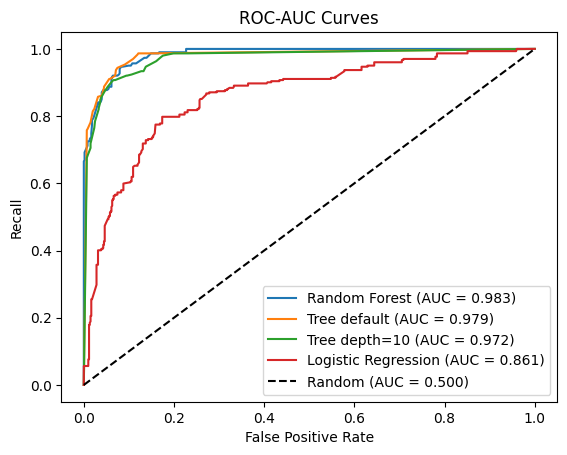

In [254]:
best_models = ['Random Forest', 'Tree default', 'Tree depth=10', 'Logistic Regression']

for name in best_models:
    model = models[name]
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        
        y_test_bin = label_binarize(y_test, classes=classes)
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.title('ROC-AUC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.legend()

Диагональная прямая на графике ROC-AUC представляет случайный классификатор, который не обладает предсказательной способностью и работает на уровне случайного угадывания.

Все лучшие модели (Random Forest, Decision Trees) демонстрируют AUC > 0.95, что свидетельствует об их исключительной эффективности в решении поставленной задачи классификации уровней адаптивности, не говоря про Logistic Regression, в сравнении с остальными тремя моделями она сильно проведает.

---

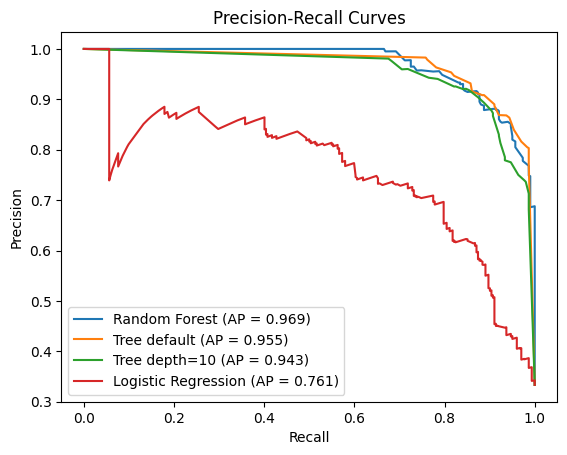

In [248]:
for name in best_models:
    model = models[name]
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        
        y_test_bin = label_binarize(y_test, classes=classes)
        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
        avg_precision = average_precision_score(y_test_bin, y_proba, average="micro")
        
        plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()

Анализ `Precision-Recall` кривой выявил различные характеристики моделей: `Logistic Regression` на низких порогах показывает большое количество ложных срабатываний с последующим улучшением точности, тогда как остальные модели (`Random Forest`, `Decision Trees`) демонстрируют стабильно высокое качество с `Average Precision` > 0.94. Это свидетельствует о выдающейся способности данных алгоритмов одновременно обеспечивать высокую точность и полноту предсказаний across всех порогов классификации, делая их более надежными для практического применения без необходимости тонкой настройки пороговых значений.

---

## 6. Сравните метрики относительно train/test, так и относительно разных моделей и ответьте на вопросы
1) Какая модель справилась лучше с поставленной задачей?
2) Имеет ли место переобучение?
3) Имеет ли место недообучение?
4) Как можно улучшить метрики моделей?

##### 1

Random Forest и Decision Tree показывают наилучшую точность, однако Tree depth=10 демонстрирует минимальное переобучение, обеспечивая оптимальный баланс между качеством и обобщающей способностью:
| Модель | Accuracy Train | Accuracy Test | F1-Score Train | F1-Score Test | ROC-AUC Train | ROC-AUC Test |
|--------|---------------|---------------|----------------|---------------|---------------|--------------|
| Tree default | 0.9347 | 0.8940 | 0.9347 | 0.8932 | 0.9929 | 0.9754 |
| Random Forest | 0.9347 | 0.8808 | 0.9343 | 0.8787 | 0.9925 | 0.9796 |
| Tree depth=10 | 0.8904 | 0.8775 | 0.8901 | 0.8771 | 0.9796 | 0.9635 |

##### 2
Да, умеренное переобучение наблюдается:

- Сильное: KNN k=3 (разница train/test accuracy = 0.0946)
- Умеренное: Tree default (разница = 0.0407), Random Forest (разница = 0.0539)
- Слабое: Tree depth=10 (разница = 0.0129) - лучший баланс

##### 3
Нет, недообучения не наблюдается:

Все модели показывают accuracy test > 0.69  
Logistic Regression (0.7219) и Tree depth=3 (0.6954) - самые слабые, но все равно приемлемые

##### 4
Рекомендации по улучшению:

- Для деревьев можно настроить гиперпарамеры и поиграться с GridSearchCV (min_samples_split, min_samples_leaf и тп)

- Для KNN можно подобрать оптимальное k (7-8) или использовать взвешенные соседи

- Попробовать ансамбли: Gradient Boosting (XGBoost, CatBoost)

- Сделать feature engineering - создать новые признаки

- Использовать кросс-валидацию для подбора параметров

### Итог: Random Forest - лучшая модель, Tree depth=10 - лучший баланс против переобучения